In [16]:
import numpy as np
import warnings
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow_hub as hub
from utils import data_splitter,text_process,build_freqs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from utils import hub_model
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())

print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.3.0
Eager mode:  True
Hub version:  0.11.0
GPU is NOT AVAILABLE


In [17]:
df = pd.read_csv('resources/dataset.csv')
df['humor']=df['humor'].map({True:1,False:0})
df.head(2)

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['humor'], test_size=0.2)
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [19]:
X_train[:5]

array(['Which came first, the chicken or the egg? neither. the cock came first.',
       "What's the etiquette on petting a baby that's been leashed to the bike rail outside starbucks?",
       "Welcome to syria! you'll have a blast :)",
       "Gop leaders may want roy moore to go away, but regular republicans aren't so sure",
       'Coming out as gay superheroes: meet six lgbt comic book characters'],
      dtype=object)

In [20]:
y_train[:5]

array([1, 1, 1, 0, 0], dtype=int64)

In [21]:

hub_model = hub_model()
hub_layer = hub.KerasLayer(hub_model, input_shape=[], dtype=tf.string, trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(6, activation='relu'))
model.add(Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

In [22]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model/best_model",
                                            save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train,y_train,epochs=40,batch_size=512,
validation_data=(X_test, y_test),verbose=1,callbacks=[stop_early,checkpoint])

Epoch 1/40
313/313 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8862WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001EAD321D558> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: model\best_model\assets


INFO:tensorflow:Assets written to: model\best_model\assets


313/313 [==============================] - 103s 330ms/step - loss: 0.3263 - accuracy: 0.8862 - val_loss: 0.1822 - val_accuracy: 0.9357
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9185WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x000001EAD32DFF78> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: model\best_model\assets


INFO:tensorflow:Assets written to: model\best_model\assets


313/313 [==============================] - 103s 329ms/step - loss: 0.2294 - accuracy: 0.9185 - val_loss: 0.1561 - val_accuracy: 0.9406
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9282WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x000001EAD3868D38> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: model\best_model\assets


INFO:tensorflow:Assets written to: model\best_model\assets


313/313 [==============================] - 103s 330ms/step - loss: 0.1999 - accuracy: 0.9282 - val_loss: 0.1513 - val_accuracy: 0.9405
Epoch 4/40
313/313 [==============================] - 99s 317ms/step - loss: 0.1829 - accuracy: 0.9332 - val_loss: 0.1531 - val_accuracy: 0.9403
Epoch 5/40
313/313 [==============================] - 100s 318ms/step - loss: 0.1674 - accuracy: 0.9378 - val_loss: 0.1620 - val_accuracy: 0.9391
Epoch 6/40
313/313 [==============================] - 98s 313ms/step - loss: 0.1575 - accuracy: 0.9402 - val_loss: 0.1703 - val_accuracy: 0.9385


In [25]:
loaded_model = tf.keras.models.load_model('model/best_model')
results = loaded_model.evaluate(X_test, y_test)

print(results)
history_dict = history.history
history_dict.keys()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1250/1250 [==============================] - 1s 501us/step - loss: 0.1513 - accuracy: 0.9405
[0.15134888887405396, 0.9404749870300293]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

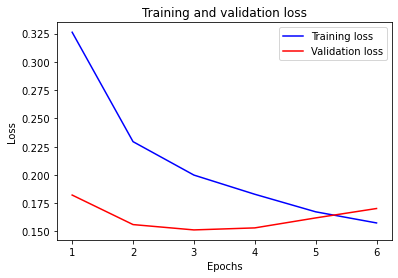

In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

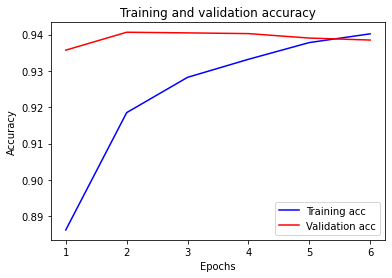

In [27]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
my_text ="What do you call a bee that can’t make up its mind? A maybe."
y_hat = model.predict([my_text])
print(y_hat)
if y_hat > 0:
    print('Humor text')
else: 
    print('Non_Humor text')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[5.819299]]
Humor text
